In [1]:
import os
import sys
file_path = globals()['_dh'][0]
root_dir = os.path.abspath(os.path.join(file_path, ''))
sys.path.append(root_dir)
sys.dont_write_bytecode = True
os.chdir(root_dir)
print(root_dir)

/Users/zhounan/Documents/Github_Project/GC_NC-Res/GC_diagnosis_model


In [2]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split,RepeatedKFold,StratifiedShuffleSplit
from model import Selection
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
##### settings #####
rng_seed = 42 # control reproducibility
ran_sta = 3 
method = "lasso"
Counts=Counter()

In [4]:
# read data for diagnosis prediction
Xtrain = pd.read_excel('Data/Xtrain.xlsx',index_col=0)
ytrain = pd.read_excel('Data/ytrain.xlsx',index_col=0)
Xtest = pd.read_excel('Data/Xtest.xlsx',index_col=0)
ytest = pd.read_excel('Data/ytest.xlsx',index_col=0)

Xtrain.drop(['sample_id'],axis=1,inplace=True)
Xtest.drop(['sample_id'],axis=1,inplace=True)

metas=list(Xtrain.columns)
ytrain = np.array(ytrain.state)
ytrain = ytrain.astype(np.float32)
ytest = np.array(ytest.state)
ytest = ytest.astype(np.float32)

Xtrain=Xtrain.values
Xtest=Xtest.values
print("train test info:")
print("train, normal-patients", np.unique(ytrain,return_counts=True))
print("test, normal-patients", np.unique(ytest,return_counts=True))

train test info:
train, normal-patients (array([0., 1.], dtype=float32), array([187,  97]))
test, normal-patients (array([0., 1.], dtype=float32), array([94, 48]))


In [5]:
def test(model, Xtest, ytest, metric='auc'):
    pred = model.predict(Xtest)
    prob = model.predict_proba(Xtest)
    print("ytest,pred:",ytest,pred)
    s = f1_score(ytest, pred)
    print("ytest,prob:",ytest,prob[:,-1])
    s1 = roc_auc_score(ytest, prob[:,-1])
    print("f1 score:", s)
    print("auroc score:", s1)
    return (s,s1)
         
def train_test(Xtrain, ytrain, Xtest, ytest, test_fn="RF", seed=12306, metric='auc'):
    model = RF(n_estimators=100,random_state=seed)
    model.fit(Xtrain, ytrain)
    print("evaluate on train set:")
    test(model, Xtrain, ytrain, metric)
    print("evaluate on test set:")
    s = test(model, Xtest, ytest, metric)
    return model, s

In [6]:
# import StandardScaler
from sklearn.preprocessing import StandardScaler

In [7]:
##### Feature selection #####
discovery_set=pd.read_excel('Data/discovery_set.xlsx',index_col=0)
discovery_set['state']=discovery_set.apply(lambda a:0 if a['type']=='N' else 1,axis=1)
labels=discovery_set['type']
plasma_df=discovery_set.copy()
batch1=plasma_df[(plasma_df['batch']=='batch1')]
batch1.reset_index(drop=True,inplace=True)
batch2=plasma_df[(plasma_df['batch']=='batch2')]
batch2.reset_index(drop=True,inplace=True)
batch3=plasma_df[plasma_df['batch']=='batch3']
batch3.reset_index(drop=True,inplace=True)

for i in range(0,10000):
    print("This is round %d"%(i))
    random_state=i
    split=StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=random_state)
    for train_index, test_index in split.split(batch1,batch1['type']):
        batch1_train_set=batch1.loc[train_index]
        batch1_test_set=batch1.loc[test_index] #batch1
    for train_index, test_index in split.split(batch2,batch2['type']):
        batch2_train_set=batch2.loc[train_index]
        batch2_test_set=batch2.loc[test_index] #batch2
    for train_index, test_index in split.split(batch3,batch3['type']):
        batch3_train_set=batch3.loc[train_index]
        batch3_test_set=batch3.loc[test_index] #batch3

    # 合并3个batch的training set 和testing set数据
    Xtrain_stratified=pd.concat([batch1_train_set,batch2_train_set,batch3_train_set],axis=0)
    Xtrain_stratified.reset_index(drop=True,inplace=True)
    Xtest_stratified=pd.concat([batch1_test_set,batch2_test_set,batch3_test_set],axis=0)
    Xtest_stratified.reset_index(drop=True,inplace=True)

    # 分类数据
    ytrain_stratified=Xtrain_stratified['state']
    ytest_stratified=Xtest_stratified['state']
    # 丢弃不需要的列
    Xtrain_stratified.drop(['Batch','type','batch','state'],axis=1,inplace=True)
    Xtest_stratified.drop(['Batch','type','batch','state'],axis=1,inplace=True)

    Xtrain=Xtrain_stratified
    Xtest=Xtest_stratified
    ytrain=pd.DataFrame(ytrain_stratified)
    ytest=pd.DataFrame(ytest_stratified)

    Xtrain.drop(['sample_id'],axis=1,inplace=True)
    Xtest.drop(['sample_id'],axis=1,inplace=True)

    metas=list(Xtrain.columns)
    ytrain = np.array(ytrain.state)
    ytrain = ytrain.astype(np.float32)
    ytest = np.array(ytest.state)
    ytest = ytest.astype(np.float32)

    Xtrain=Xtrain.values
    Xtest=Xtest.values
    class ArgsClass:
        def __init__(self, k=5, alpha=0.05):
            self.k=k
            self.alpha=alpha
            
    args=ArgsClass(k=10, alpha=0.005)
    sel = Selection(method, args)

    sel.fit(StandardScaler().fit_transform(Xtrain), ytrain)  # select on whole training set
    mb = sel.mb_
    print("selected feature index: ", mb)
    print("selected meta names: ", [metas[x] for x in mb])
    print("with selected featues:")
    Counts=Counter(mb)+Counts

##### select top rank features #####
Counts_metas = pd.DataFrame(Counts.most_common(),columns=['metas_index',"counts"])
Counts_metas['metas'] = Counts_metas.apply(lambda a:metas[a['metas_index']],axis=1)
# 'Glycerate-2P_Glycerate-3P_neg-006','Citraconic acid_neg-025','Pyridoxine_pos-137','Argininosuccinic acid_pos-039'
# The above metabolites are excluded as characteristics due to poor peak shapes in mass spectrometry
Counts_metas_selected=Counts_metas[~Counts_metas['metas'].isin(['Glycerate-2P_Glycerate-3P_neg-006','Citraconic acid_neg-025','Pyridoxine_pos-137','Argininosuccinic acid_pos-039'])]
Counts_metas_selected.reset_index(drop=True,inplace=True)
Counts_metas=Counts_metas_selected
selected_feature_index=list(Counts_metas['metas_index'][0:10])

This is round 0
imp: 0.04919352914170355
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000), max_features=10,
                prefit=True)
self.mb_: [  4  10  53  78 110 111 113 137 138 140]
over max_features [  4  10  53  78 110 111 113 137 138 140]
selected feature index:  [  4  10  53  78 110 111 113 137 138 140]
selected meta names:  ['2-Aminooctanoic acid_pos-006', 'Acetylcarnitine_pos-029', 'Hypoxanthine_pos-096', 'S-Adenosyl-methionine_pos-139', 'Citraconic acid_neg-025', 'Citrate_neg-026', 'Fumaric acid_neg-036', 'Succinate_neg-079', 'Taurine_neg-080', 'Uridine_neg-088']
with selected featues:
This is round 1
imp: 0.04690643387256415
sel: SelectFromModel(estimator=Lasso(alpha=0.005, max_iter=10000), max_features=10,
                prefit=True)
self.mb_: [  4  44  59 111 113 122 133 137 139 140]
over max_features [  4  44  59 111 113 122 133 137 139 140]
selected feature index:  [  4  44  59 111 113 122 133 137 139 140]
selected meta names:  ['2-Aminooctanoic aci

In [8]:
# Train a random forest model using the selected features.
s=[]
s1=[]
model = RF(n_estimators=100,random_state=12306)
model.fit(Xtrain[:,Counts_metas['metas_index'][0:10]], ytrain)
pred = model.predict(Xtest[:,Counts_metas['metas_index'][0:10]])
prob = model.predict_proba(Xtest[:,Counts_metas['metas_index'][0:10]])
print("ytest,pred:",ytest,pred)
s.append(f1_score(ytest, pred))
print("ytest,prob:",ytest,prob[:,-1])
s1.append(roc_auc_score(ytest, prob[:,-1]))
print("f1 score:", s)
print("auroc score:", s1)

ytest,pred: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
ytest,prob: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [9]:
n_bootstraps = 1000
def CI(y_true, y_pred):
    bootstrapped_scores = []
    print("auroc score:", roc_auc_score(y_true, y_pred))
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
        confidence_lower, confidence_upper))
    return confidence_lower, confidence_upper

auroc score: 0.9787234042553191
Confidence interval for the score: [0.962 - 0.993]


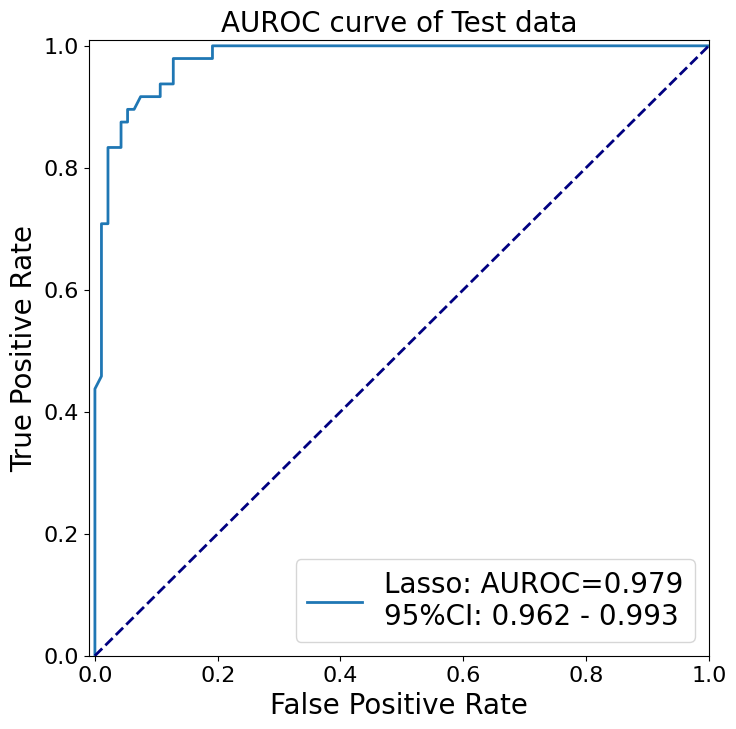

In [10]:
# Draw the AUROC curve for the test dataset
y_pred=prob[:,-1]
plt.figure(figsize=(8, 8))
exp_to_run='AUROC curve of Test data'
fpr, tpr, _ = roc_curve(ytest, y_pred)
r , l = CI(ytest, y_pred)
raw=roc_auc_score(ytest,y_pred)
tex = 'Lasso: AUROC={:0.3f}\n95%CI: {:0.3f} - {:0.3f}'.format(raw,r,l)
plt.plot(fpr, tpr, lw=2, label=tex)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontdict={'size'   : 20})
plt.ylabel('True Positive Rate', fontdict={'size'   : 20})
plt.title(exp_to_run, fontdict={'size'   : 20})
plt.yticks(size = 16) 
plt.xticks(size = 16)  
plt.legend(loc="lower right",fontsize=20)
plt.savefig("Figures/{}_roc.pdf".format("Test"))
plt.show()

In [11]:
imp=model.feature_importances_
feature_importances=pd.concat([pd.DataFrame(Counts_metas['metas'][0:10]),pd.DataFrame(imp)],axis=1)
feature_importances.columns=['feature_name','importance_score']
feature_importances

feature_name  importance_score
0              Succinate_neg-079          0.261896
1           Fumaric acid_neg-036          0.067519
2                Uridine_neg-088          0.170544
3      Pyroglutamic acid_neg-072          0.105982
4                Citrate_neg-026          0.089167
5  S-Adenosyl-methionine_pos-139          0.094654
6                 Lysine_pos-105          0.041704
7   2-Aminooctanoic acid_pos-006          0.071296
8           Hypoxanthine_pos-096          0.050900
9                    GSH_pos-085          0.046336

In [12]:
####### Using external test dataset to validate the model.
# read external test data
Xexternal_test = pd.read_excel('Data/Xexternal_test.xlsx',index_col=0)
yexternal_test = pd.read_excel('Data/yexternal_test.xlsx',index_col=0)

yexternal_test=pd.DataFrame(yexternal_test)
Xexternal_test.drop(['sample_id'],axis=1,inplace=True)
metas=list(Xexternal_test.columns)

yexternal_test = np.array(yexternal_test.state)
yexternal_test = yexternal_test.astype(np.float32)
Xexternal_test= Xexternal_test.values
print("test, normal-patients", np.unique(yexternal_test,return_counts=True))

external_test_s=[]
external_test_s1=[]
external_test_pred = model.predict(Xexternal_test[:,selected_feature_index])
external_test_prob = model.predict_proba(Xexternal_test[:,selected_feature_index])
print("ytest,pred:",yexternal_test,external_test_pred)
external_test_s.append(f1_score(yexternal_test, external_test_pred))
print("ytest,prob:",yexternal_test,external_test_prob[:,-1])
external_test_s1.append(roc_auc_score(yexternal_test, external_test_prob[:,-1]))
print("f1 score:", external_test_s)
print("auroc score:", external_test_s1)

test, normal-patients (array([0., 1.], dtype=float32), array([32, 63]))
ytest,pred: [1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.] [1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.]
ytest,prob: [1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.] [0.79 0.49 0.74 0.18 0.2  0.68 0.6

auroc score: 0.9312996031746033
Confidence interval for the score: [0.887 - 0.97]


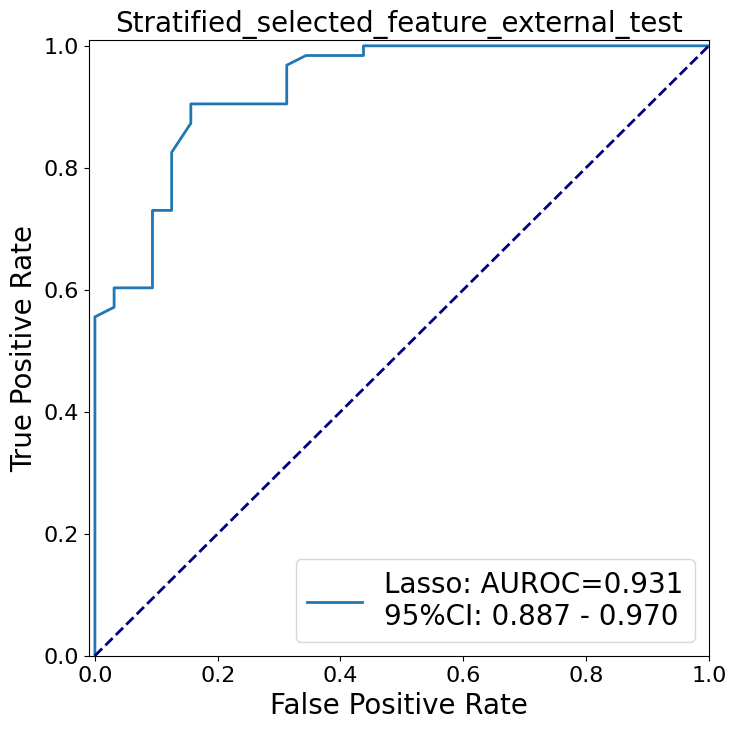

In [13]:
# Draw the AUROC curve for the external test dataset
y_pred_external=external_test_prob[:,-1]
plt.figure(figsize=(8, 8))
exp_to_run='Stratified_selected_feature_external_test'
fpr, tpr, _ = roc_curve(yexternal_test, y_pred_external)
r , l = CI(yexternal_test, y_pred_external)
raw=roc_auc_score(yexternal_test, y_pred_external)
tex = 'Lasso: AUROC={:0.3f}\n95%CI: {:0.3f} - {:0.3f}'.format(raw,r,l)
plt.plot(fpr, tpr, lw=2, label=tex)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontdict={'size'   : 20})
plt.ylabel('True Positive Rate', fontdict={'size'   : 20})
plt.title(exp_to_run, fontdict={'size'   : 20})
plt.yticks(size = 16) 
plt.xticks(size = 16)  
plt.legend(loc="lower right",fontsize=20)
plt.savefig("Figures/{}_external_test_roc.pdf".format("Test"))
plt.show()